In [5]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from pybird_dev import pybird
import os

ModuleNotFoundError: No module named 'common'

In [ ]:
font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [ ]:
from scipy.optimize import fsolve

def get_masses(sum_masses, hierarchy='NH'):
    # a function returning the three masses given the Delta m^2, the total mass, and the hierarchy (e.g. 'IN' or 'IH')
    # Values are in the latest PDG
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # Normal hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_NH and deletes M_tot_NH
        delta_m_squared_21 = 7.37e-5
        delta_m_squared_31 = 2.56e-3
        def m1_func(m1, M_tot):
            return M_tot**2 - (m1 + np.sqrt(m1**2 + delta_m_squared_21) + np.sqrt(m1**2 + delta_m_squared_31))**2
        m1, opt_output, success, output_message = fsolve(
            m1_func, sum_masses/3., (sum_masses), full_output=True, xtol=1e-04, maxfev=500)
        m1 = m1[0]
        m2 = (delta_m_squared_21 + m1**2.)**0.5
        m3 = (delta_m_squared_31 + m1**2.)**0.5
        return m1, m2, m3
    else:
        return None

In [ ]:
def load_cosmo(basedir, chainname, skycut=1, nu=False):
    bf = np.loadtxt(os.path.join(basedir, chainname, '%s.bestfit') % chainname)
    if bf[2]>2.: bf[2] /= 100.
    if nu: 
        cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], 
                    'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': r'%g, %g, %g' % get_masses(bf[5])}
            
        print (cosmo)
    else: cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], }
    if nu:
        if skycut ==1: b1c2 = np.array([bf[6], bf[7]])
        elif skycut ==2: b1c2 = np.array([bf[8], bf[9]])
        elif skycut ==3: b1c2 = np.array([bf[10], bf[11]])
        elif skycut ==4: b1c2 = np.array([bf[12], bf[13]])
    else: b1c2 = np.array([bf[5], bf[6]])
    return cosmo, b1c2

In [2]:
cosmo, b1c2 = load_cosmo('/Users/pierre/Documents/github/montepython_public-3.3/cf/2021/cheng/', 
                         'boss_pierrewin', nu=True)

NameError: name 'load_cosmo' is not defined

In [3]:
zpk = 0.57
M = Class()
# cosmo = {'ln10^{10}A_s': 3.044, 'n_s': 0.9649, 'h': 0.6736, 'omega_b': 0.02237, 'omega_cdm': 0.120 }
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
M.compute()
kk = np.logspace(-5, 0, 200) # k in h/Mpc
Pk = np.array([M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]) # P(k) in (Mpc/h)**3

NameError: name 'cosmo' is not defined

In [7]:
bs = [b1c2[0], b1c2[1], -1.17855741,  0.41561274, -3.4946073, 0.99198482, -1.61644689]
# bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]
bdict = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), 
 "cct": bs[3], "cr1": bs[4], 'ce0': bs[5], 'ce2': bs[6], 'ce1': 0. }   
print (bdict)

{'b1': 1.884409, 'b2': 0.30485020895752224, 'b3': -1.17855741, 'b4': 0.30485020895752224, 'cct': 0.41561274, 'cr1': -3.4946073, 'ce0': 0.99198482, 'ce2': -1.61644689, 'ce1': 0.0}


### PS

In [12]:
from numpy.linalg import inv
datapath = '/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/'
kb, pb1,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzNGC.dat'), unpack=True)
_, pb2,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzSGC.dat'), unpack=True)
cov1 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzNGC.dat') )
cov2 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzSGC.dat') )
cov = inv ( inv(cov1) + inv(cov2) )
pb = np.dot( np.dot(pb1, inv(cov1)) + np.dot(pb2, inv(cov2)) , cov ) # CMASS NGC + SGC
kb = kb.reshape(3,-1)[0]
pb = pb.reshape(3,-1)
sb = np.sqrt(np.diag(cov)).reshape(3,-1)
eb = (sb/pb)[:,np.where(kb<0.35)[0]]
sb = sb[:,np.where(kb<0.35)[0]]
kb = kb[np.where(kb<0.35)[0]]
kk = kb

In [69]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kk, 'z': zpk, 'kmax': kk[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7
        })
correlator.compute(cosmo, module='class')
pk = correlator.get(bdict)

In [70]:
pknnlo = correlator.getnlo(bdict)

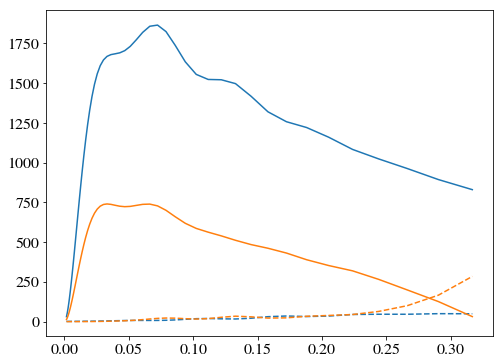

In [71]:
plt.plot(kk, kk*pk[0], 'C0')
plt.plot(kk, kk*pknnlo[0], 'C0--')
plt.plot(kk, kk*pk[1], 'C1')
plt.plot(kk, kk*pknnlo[1], 'C1--')

(0, 2)

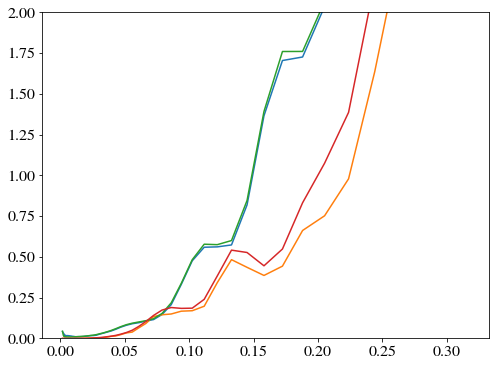

In [72]:
bnnlo = 0.5
plt.plot(kk, bnnlo*pknnlo[0]/pk[0]/eb[0])
plt.plot(kk, bnnlo*pknnlo[1]/pk[1]/eb[1])
plt.plot(kk, bnnlo*pknnlo[0]/sb[0])
plt.plot(kk, bnnlo*pknnlo[1]/sb[1])
plt.ylim(0, 2)

### CF

In [8]:
datapath = '/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/'
xb, cb = np.loadtxt( os.path.join(datapath, 'CF', 'cf_ell3_CMASS_data.dat'), unpack=True)
cov = np.loadtxt( os.path.join(datapath, 'CF', 'cov_cf_ell3_CMASS.dat') )
xb = xb.reshape(3,-1)[0]
cb = cb.reshape(3,-1)
sb = np.sqrt(np.diag(cov)).reshape(3,-1)
eb = (sb/cb)
sb = sb
ss = xb

In [9]:
bcf = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), "cct": bs[3], "cr1": bs[4] }   
correlator = pybird.Correlator()
correlator.set({
    'output': 'bCf', 'multipole': 2, 'xdata': ss, 'z': zpk, 'km': 0.7, 'knl': 0.7, 'with_resum':False,
        })
correlator.compute(cosmo, module='class')
cf = correlator.get(bcf)

In [10]:
cfnnlo = correlator.getnlo(bdict, k=correlator.co.k)

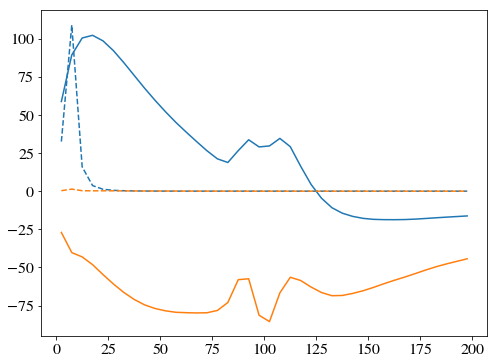

In [11]:
plt.plot(ss, ss**2*cf[0], 'C0')
plt.plot(ss, ss**2*cfnnlo[0], 'C0--')
plt.plot(ss, ss**2*cf[1], 'C1')
plt.plot(ss, ss**2*cfnnlo[1], 'C1--')

(0, 2)

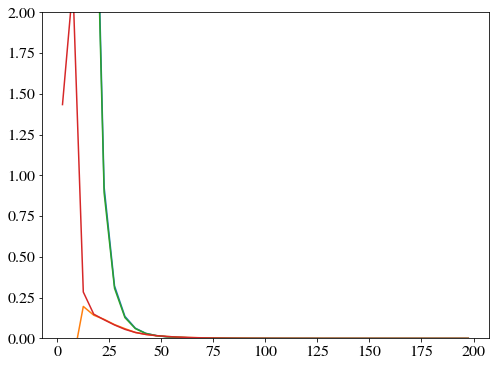

In [15]:
bnnlo = 1.
plt.plot(ss, bnnlo*cfnnlo[0]/cf[0]/eb[0])
plt.plot(ss, bnnlo*cfnnlo[1]/cf[1]/eb[1])
plt.plot(ss, bnnlo*cfnnlo[0]/sb[0])
plt.plot(ss, bnnlo*cfnnlo[1]/sb[1])
plt.ylim(0, 2)